In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "mostafa77" # username from the json file
os.environ['KAGGLE_KEY'] = "347368f5c64dba7e88eaa79d996db0ec" # key from the json file

In [0]:
!kaggle competitions download -c airbnb-recruiting-new-user-bookings

In [0]:
!unzip countries.csv.zip
!unzip /content/age_gender_bkts.csv.zip
!unzip /content/sample_submission_NDF.csv.zip
!unzip /content/sessions.csv.zip
!unzip /content/test_users.csv.zip
!unzip /content/train_users_2.csv.zip

In [0]:
import pandas as pd

In [0]:
train_users = pd.read_csv('train_users_2.csv')
test_users = pd.read_csv('test_users.csv')
sessions = pd.read_csv('sessions.csv')
#age_gender_bkts = pd.read_csv('age_gender_bkts.csv')


# helper functions

In [7]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict
def numericalize(df, col, name, max_n_cat):

    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):

    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dicaffiliate_providert = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def split_vals(a,n): return a[:n].copy(), a[n:].copy()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
def nn_numericalize(df, col, name, max_n_cat, cat_vars=None):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes
    else:
      if  name in cat_vars:
        df[name] = pd.Categorical(col).codes
       
def nn_proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None, cat_vars=None):

    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): nn_numericalize(df, c, n, max_n_cat, cat_vars=cat_vars)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res


# Preprocessing

In [0]:
train_users = pd.read_csv('train_users_2.csv')
test_users = pd.read_csv('test_users.csv')

In [0]:
train_users.drop(['id', 'date_first_booking'], axis=1, inplace=True)
test_users.drop(['id', 'date_first_booking'], axis=1, inplace=True)

df = pd.concat((train_users, test_users), axis=0, ignore_index=True, sort=True)

In [0]:
import numpy as np
df.gender.replace('-unknown-', np.nan, inplace=True)
df.language.replace('-unknown-', np.nan, inplace=True)

In [12]:
'-unknown-' in df.gender.unique()

False

In [13]:
users_nan = (df.isnull().sum() / df.shape[0]) * 100
users_nan

affiliate_channel           0.000000
affiliate_provider          0.000000
age                        42.412365
country_destination        22.535538
date_account_created        0.000000
first_affiliate_tracked     2.208335
first_browser               0.000000
first_device_type           0.000000
gender                     46.990169
language                    0.000363
signup_app                  0.000000
signup_flow                 0.000000
signup_method               0.000000
timestamp_first_active      0.000000
dtype: float64

In [0]:
df['date_account_created'] = pd.to_datetime(df['date_account_created'])
df['date_first_active'] = pd.to_datetime((df.timestamp_first_active // 1000000), format='%Y%m%d')
df.drop('timestamp_first_active', axis=1, inplace=True)

# Handling outliers

In [0]:
df.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [0]:
import numpy as np
data = np.array(df.age)
data = data[~np.isnan(data)]

{'boxes': [<matplotlib.lines.Line2D at 0x7f316fa3bbe0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3175ac2748>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3175acf208>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f3175ac2e48>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3175ac2048>,
  <matplotlib.lines.Line2D at 0x7f3175ac23c8>]}

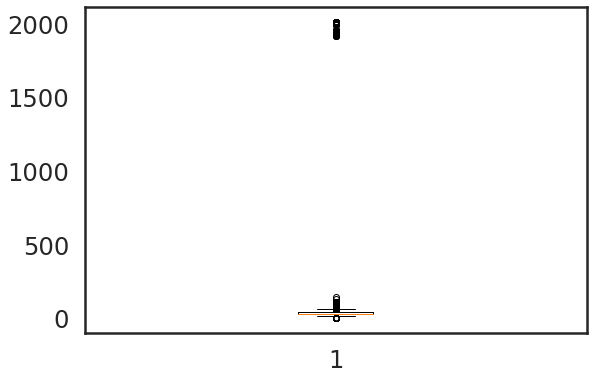

In [0]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
ax.boxplot(data)

In [0]:
df[df.age > 100]['age'].describe()

count    2690.000000
mean      690.957249
std       877.927570
min       101.000000
25%       105.000000
50%       105.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

In [0]:
df[df.age < 18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

In [0]:
df.loc[df.age > 100, 'age'] = np.nan
df.loc[df.age < 16, 'age'] = np.nan

{'boxes': [<matplotlib.lines.Line2D at 0x7f316f411128>],
 'caps': [<matplotlib.lines.Line2D at 0x7f316f411a20>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f316f4074e0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f316f407160>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f316f4112b0>,
  <matplotlib.lines.Line2D at 0x7f316f4116a0>]}

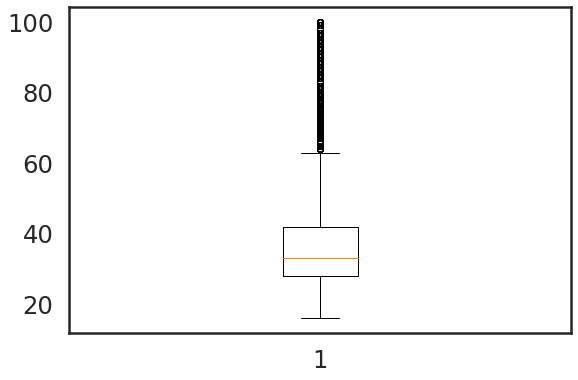

In [0]:
data = np.array(df.age)
data = data[~np.isnan(data)]
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.boxplot(data)

# Extracting day, week day, month from dates

In [0]:
df['weekday_account_created'] = df.date_account_created.dt.weekday_name
df['day_account_created'] = df.date_account_created.dt.day
df['month_account_created'] = df.date_account_created.dt.month

df['weekday_first_active'] = df.date_first_active.dt.weekday_name
df['day_first_active'] = df.date_first_active.dt.day
df['month_first_active'] = df.date_first_active.dt.month

df.drop( ['date_account_created', 'date_first_active'], axis=1, inplace=True)

# predect age, gender missing values

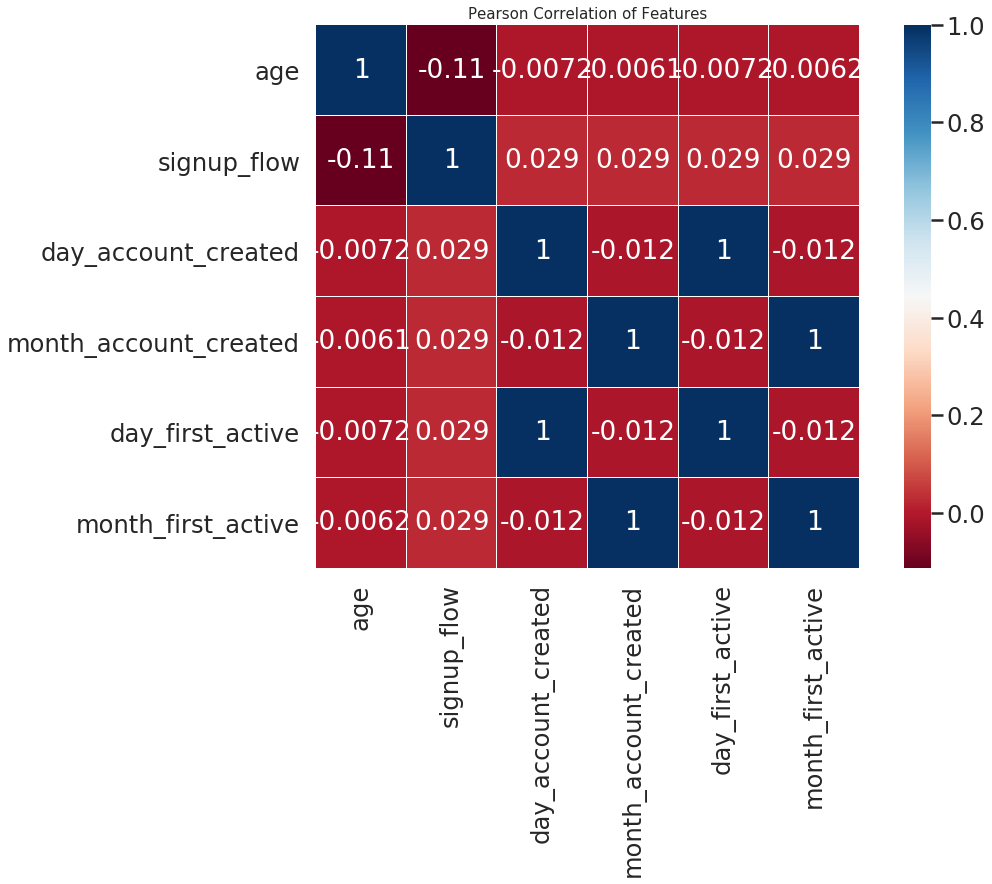

In [0]:
import seaborn as sns

colormap = plt.cm.RdBu
plt.figure(figsize=(16,10))
plt.title('Pearson Correlation of Features', y=1.0, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True,)
# Note that the categorical features have been neglected in the
# correlation matrix.

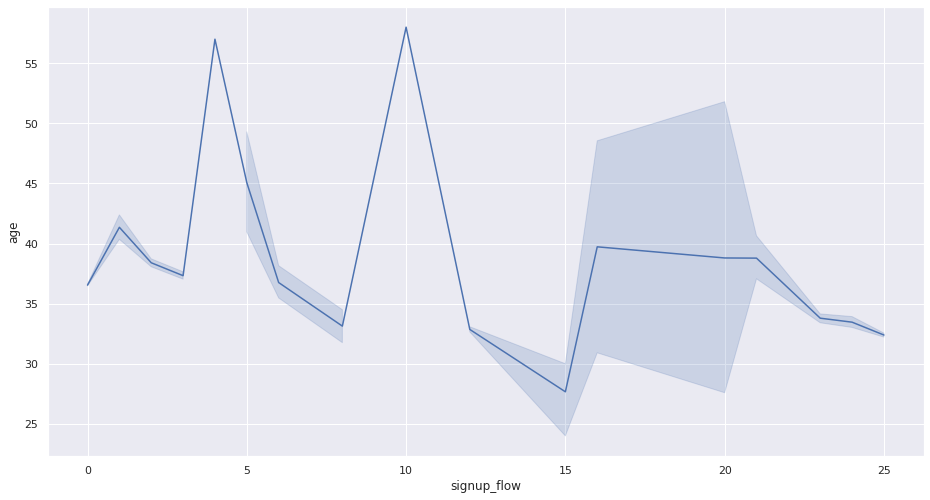

In [0]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(x="signup_flow", y="age", data=df)

In [0]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

ind_train = df[df['age'].notnull()]['signup_flow']
ind_test = df[df['age'].isnull()]['signup_flow']

dep_train = df[df['age'].notnull()]['age']
dep_test = df[df['age'].isnull()]['age']


In [0]:
xxx = np.array([ind_train]).reshape(-1, 1)
yyy = np.array([dep_train]).reshape(-1, 1)
zzz = np.array([ind_test]).reshape(-1, 1)

In [0]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

age_predector = RandomForestRegressor(n_estimators=10, n_jobs=-1, oob_score=False)

age_predector.fit(xxx,yyy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
predicted = age_predector.predict(zzz).astype(int)


In [0]:
age_null_indxs = df.age.isnull()

In [0]:
df.age[age_null_indxs] = predicted

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
###############        assigning mean or mode to nulls(instead of predecting)  ################

In [0]:
age_null_indxs = df.age.isnull()
df.age[age_null_indxs] = int(df.age.mean())

In [0]:
gender_null_idxs = df.gender.isnull()
df.gender[gender_null_idxs] = 'FEMALE'

In [0]:
language_null_idxs = df.language.isnull()
df.language[language_null_idxs] = 'en'

In [0]:
fat_null_idxs = df.first_affiliate_tracked.isnull()
df.first_affiliate_tracked[fat_null_idxs] = 'untracked'

# convert entire df to numeric values

In [0]:
x, y, nas = proc_df(df,'country_destination')
#x.drop('age_na', axis=1, inplace=True)

n_test = len(test_users)  # same as Kaggle's test set size
n_trn = len(df)-n_test

X_train, X_test = split_vals(x, n_trn)
y_train, y_test = split_vals(y, n_trn)



# build XGBOOST model

In [0]:
import xgboost as xgb
params = {'max_depth': 10,
    'learning_rate': 1,
    'n_estimators': 5,
    'objective': 'multi:softprob',
    'num_class': 12,
    'gamma': 0,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'base_score': 0.5,
    'missing': None,
    'nthread': 4,
    'seed': 42
          }
num_boost_round = 5



In [0]:
print("Train a XGBoost model")
xg_train = xgb.DMatrix(X_train, label=y_train)#Specifying the hyperparameters
gbm = xgb.train(params, xg_train, num_boost_round)

In [0]:
#############   CALCULATE NDCG ON TRAINING DATA #########################  3
y_pred = gbm.predict(xgb.DMatrix(X_train))
true_relevance = np.zeros_like(y_pred)
for i in range(len(true_relevance)):
  indx = y_train[i]
  true_relevance[i][indx]=1

from sklearn.metrics import ndcg_score
ndcg_score(true_relevance, y_pred)

0.8376089698333912

In [0]:
test_users = pd.read_csv('test_users.csv')
id_test = test_users['id']

In [0]:
y_pred = gbm.predict(xgb.DMatrix(X_test))
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += label_encoder.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

In [0]:
predict = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

In [0]:
predict.to_csv('prediction.csv',index=False)

# SPLIT DATA TO TRAIN, VALID

In [0]:
n_valid   = int(0.2 * len(X_train))  # same as Kaggle's test set size
n_new_trn = len(X_train)-n_valid

X_new_train, X_valid = split_vals(X_train, n_new_trn)
y_new_train, y_valid = split_vals(y_train, n_new_trn)

# Random forest model 

In [0]:
from sklearn.ensemble import  RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, n_jobs=-1) 

model.fit(X_new_train,y_new_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:

def scoring_fn(model, data_to_score, labels_to_pred=None, test_for_csv=False ):
  tree_predictions = np.array([tree.predict(data_to_score) for tree in model.estimators_])

  y_pred_trees=[]
  for j in range(tree_predictions.shape[1]):
    pred_list = list(tree_predictions[:,j])
    top_k=[]
    #print('start:',pred_list)
    while pred_list:
      maximum = max(set(pred_list), key=lambda x: pred_list.count(x))
      #print(maximum)
      top_k.append(maximum)
      while(maximum in pred_list):
        pred_list.remove(maximum)
      #print(pred_list)
      if len(top_k) == 5:
        break
    y_pred_trees.append(top_k)

  y_pred_trees_arr = np.zeros((len(data_to_score),12))
  for i in range (len(y_pred_trees_arr)):
    relev = 12
    for doc in y_pred_trees[i]:
      y_pred_trees_arr[i][int(doc)] = relev
      relev -=1
  if not test_for_csv:
    true_relevance = np.zeros_like(y_pred_trees_arr)
    for i in range(len(true_relevance)):
      indx = labels_to_pred[i]
      true_relevance[i][indx]=1
  if test_for_csv:
    return y_pred_trees_arr
  else:
    return ndcg_score(true_relevance, y_pred_trees_arr)

In [0]:

print('training score :'  , scoring_fn(model,X_new_train,y_new_train))
print('validation score :', scoring_fn(model,X_valid,y_valid))

training score : 0.9795342324160299
validation score : 0.8253954751378056


In [0]:
#### after min_sample_leaf = 3
print('training score :'  , scoring_fn(model,X_new_train,y_new_train))
print('validation score :', scoring_fn(model,X_valid,y_valid))

training score : 0.8957879921790012
validation score : 0.8362531356194036


In [0]:
label_encoder = LabelEncoder()
label_encoder.fit(train_users.country_destination)
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += label_encoder.inverse_transform(np.argsort(y_pred_trees_arr[i])[::-1])[:5].tolist()

predict3 = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

predict3.to_csv('prediction3.csv',index=False)

# Handling Imbalanced Data


In [0]:
def plot_classes(df):
  counts = df.country_destination.value_counts() 
  width = 0.4
  sns.set(rc={'figure.figsize':(15.7,8.27)})
  counts.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Male', rot=0)
  plt.legend()
  plt.xlabel('Destination Country')
  plt.ylabel('count')
  sns.despine()
  plt.show()

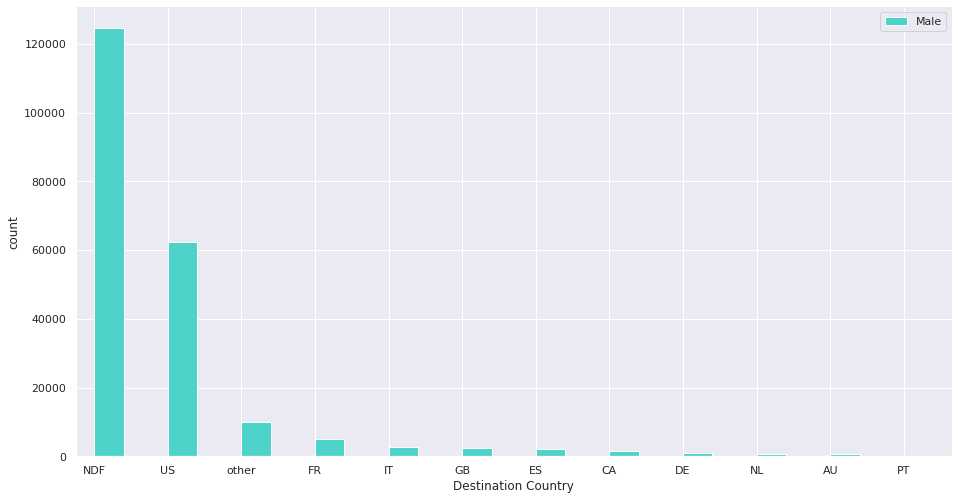

In [0]:
plot_classes(train_users)

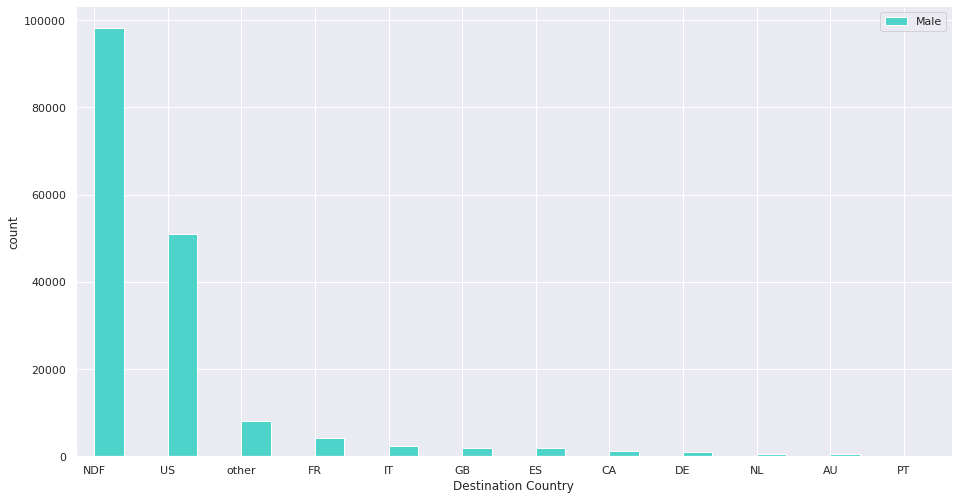

In [0]:
plot_classes(df[:len(X_new_train)])

In [0]:
label_encoder.classes_

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

In [0]:
u, c = np.unique(y_new_train, return_counts=True)
sorted(c)

[163, 462, 602, 911, 1128, 1831, 1889, 2272, 4175, 8103, 51033, 98192]

In [0]:
'''
n=15000
d = {0:n,
     1:n,
     2:n,
     3:n,
     4:n,
     5:n,
     6:n,
     8:n,
     9:n,
     11:n }

dd = {7 :40000,
      10:40000}

smote = SMOTE(sampling_strategy= d)
X_sm, y_sm = smote.fit_sample(X_new_train, y_new_train)

rus = RandomUnderSampler(sampling_strategy=dd )
X_rus, y_rus = rus.fit_sample(X_new_train, y_new_train)

u, c = np.unique(y_sm, return_counts=True)
sorted(c)
'''

In [0]:
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

tl = TomekLinks(sampling_strategy='majority' )
rus = RandomUnderSampler(sampling_strategy={7:20000,10:20000} )
smt = SMOTETomek(ratio='auto')

X_tl, y_tl = tl.fit_sample(X_new_train, y_new_train)
X_rus, y_rus = rus.fit_sample(X_tl, y_tl)
X_smt, y_smt = smt.fit_sample(X_rus, y_rus)

In [0]:
from sklearn.ensemble import  RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,min_samples_leaf=3,  n_jobs=-1) 

model.fit(X_sm, y_sm)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
y_sm.shape

(299225,)

In [0]:
print('training score :'  , scoring_fn(model,X_new_train,y_new_train))
print('validation score :', scoring_fn(model,X_valid,y_valid))

training score : 0.8869236867573137
validation score : 0.8315440779324792


In [0]:
print('training score :'  , scoring_fn(model,X_new_train,y_new_train))
print('validation score :', scoring_fn(model,X_valid,y_valid))

training score : 0.9034998505521411
validation score : 0.8330558733713016


In [0]:
y_pred_trees_arr = scoring_fn(model, X_test, test_for_csv=True)
test_users = pd.read_csv('test_users.csv')
id_test = test_users['id']
label_encoder = LabelEncoder()
label_encoder.fit(train_users.country_destination)
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += label_encoder.inverse_transform(np.argsort(y_pred_trees_arr[i])[::-1])[:5].tolist()

predict4 = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

predict4.to_csv('prediction4.csv',index=False)

# feature importance

In [0]:
dictt = {k:v for k,v in zip(X_new_train.columns, model.feature_importances_)}
ser = pd.Series(dictt) 


In [0]:
ser

affiliate_channel          0.032085
affiliate_provider         0.019888
age                        0.212811
first_affiliate_tracked    0.036226
first_browser              0.053643
first_device_type          0.030689
gender                     0.022482
language                   0.006547
signup_app                 0.007542
signup_flow                0.033356
signup_method              0.054963
weekday_account_created    0.061353
day_account_created        0.113693
month_account_created      0.069877
weekday_first_active       0.061168
day_first_active           0.113942
month_first_active         0.069735
dtype: float64

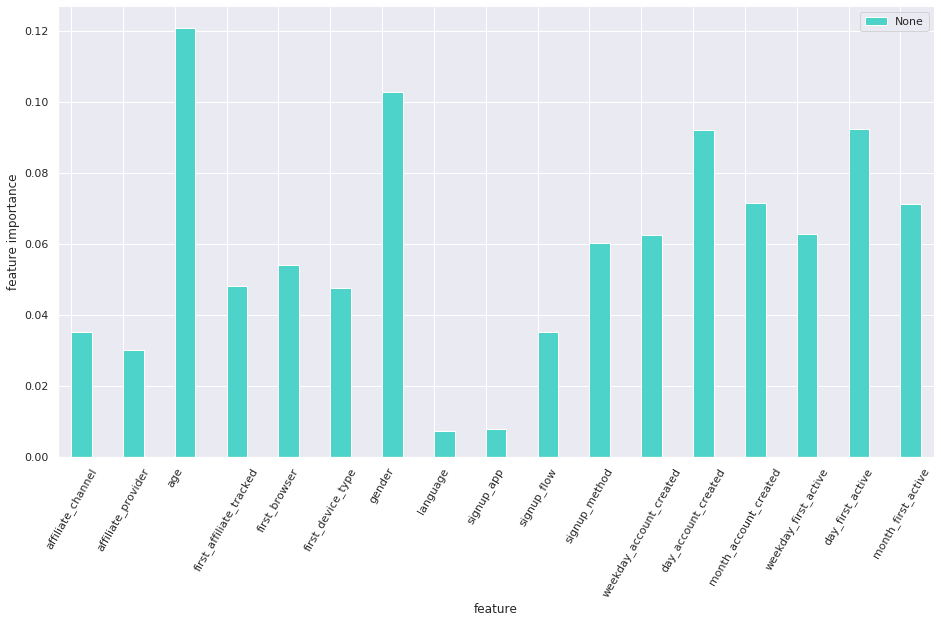

In [0]:
 
width = 0.4
sns.set(rc={'figure.figsize':(15.7,8.27)})
ser.plot(kind='bar', width=width, color='#4DD3C9', position=0, rot=60)
plt.legend()
plt.xlabel('feature')
plt.ylabel('feature importance')
sns.despine()
plt.show()

In [0]:
to_keep = []
for k,v in dictt.items():
  if v>0.04:
    to_keep.append(k)
to_keep.append('country_destination')
df_keep = df[to_keep].copy()

In [0]:
to_keep

['age',
 'first_browser',
 'signup_method',
 'weekday_account_created',
 'day_account_created',
 'month_account_created',
 'weekday_first_active',
 'day_first_active',
 'month_first_active',
 'country_destination']

In [0]:
x, y, nas = proc_df(df_keep,'country_destination')

n_test = len(test_users)  # same as Kaggle's test set size
n_trn = len(df)-n_test

X_train, X_test = split_vals(x, n_trn)
y_train, y_test = split_vals(y, n_trn)

n_valid   = int(0.2 * len(X_train))  # same as Kaggle's test set size
n_new_trn = len(X_train)-n_valid

X_new_train, X_valid = split_vals(X_train, n_new_trn)
y_new_train, y_valid = split_vals(y_train, n_new_trn)

In [0]:
model = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, n_jobs=-1,) 

model.fit(X_new_train,y_new_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
print('training score :'  , scoring_fn(model,X_new_train,y_new_train))
print('validation score :', scoring_fn(model,X_valid,y_valid))

training score : 0.8895158709432415
validation score : 0.8366818425104855


# Neural Network

In [0]:
cat_vars = ['affiliate_channel','affiliate_provider','first_affiliate_tracked',
            'first_browser','first_device_type','gender', 'language', 'signup_app', 
            'signup_flow', 'signup_method','weekday_account_created', 'day_account_created',
            'month_account_created', 'weekday_first_active', 'day_first_active',
            'month_first_active']

In [0]:
df_test = df.copy()

In [0]:
x, y, nas = nn_proc_df(df_test,'country_destination',cat_vars=cat_vars)

n_test = len(test_users)  
n_trn = len(df)-n_test

nX_train, nX_test = split_vals(x, n_trn)
ny_train,   _     = split_vals(y, n_trn)

n_valid   = int(0.2 * len(nX_train))  
n_new_trn = len(nX_train)-n_valid

nX_new_train, nX_valid = split_vals(nX_train, n_new_trn)
ny_new_train, ny_valid = split_vals(ny_train, n_new_trn)

In [0]:
import torch

train_tensor = torch.from_numpy(nX_new_train.values).cuda()
train_labels = torch.from_numpy(ny_new_train).long().cuda()

valid_tensor = torch.from_numpy(nX_valid.values)
valid_labels = torch.from_numpy(ny_valid).long()

test_tensor = torch.from_numpy(nX_test.values)

from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(train_tensor, train_labels)
valid_data = TensorDataset(valid_tensor, valid_labels)
#test_data  = TensorDataset()

# dataloaders
batch_size = 1024
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Batching for test
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
#test_loader = DataLoader(test_data, shuffle=False, batch_size=len(test_data))

In [35]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
import re
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F


class neural_network3(nn.Module):

    def get_dims(self, df, cat_vars):
        #print('get dim start')
        var_szs = [len(set(df[var])) for var in cat_vars]
        #a = [min(set(df[var])) for var in cat_vars]
        #var_szs = [v+r for v,r in zip(var_szs,a)]
        emb_dims = [min(50, (c+1)//2) for c in var_szs]

        len_numeric_vars=0
        for col in df.columns:
          if not(col in cat_vars):
            len_numeric_vars+=1    
        avg = int(sum(emb_dims)/len(emb_dims))
        inp_sz = avg *len_numeric_vars  + sum(emb_dims) 
        return var_szs, emb_dims, int(inp_sz), avg

    def __init__(self, df, cat_vars, output_size):
        super().__init__()
        #self.orderd_cols = df.columns
        #print('start')
        self.cols_dic   = {i:col for i,col in enumerate(df.columns)}
        self.cat_dict   = {}
        self.numer_dict = {}
        for i in range(len(df.columns)):
          if(self.cols_dic[i] in cat_vars):
            self.cat_dict[i] = self.cols_dic[i] 
          else:
            self.numer_dict[i] = int(df[self.cols_dic[i]].mean())

        #print('cols_dic',self.cols_dic)
        #print('cat_dict',self.cat_dict)
        #print('numer_dict',self.numer_dict)
        var_szs, emb_dims, inp_sz, numer_var_sz = self.get_dims(df, cat_vars)
        self.numer_sz = numer_var_sz
        self.inp_sz = inp_sz
        self.embedd_layers = nn.ModuleList([nn.Embedding(c, e) for c,e in zip(var_szs,emb_dims) ])
        self.emb_lyr_dic  = {k:v for k,v in zip(self.cat_dict.keys(), self.embedd_layers )}
        #print(self.emb_lyr_dic)
        self.bn1 = nn.BatchNorm1d(num_features=inp_sz)
        self.fc1 = nn.Linear(inp_sz, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.dropout = nn.Dropout(0.25)

    def construct_inp_vector(self,x):
        #print('x:',x,x.shape)
        final_inp_vctr = torch.zeros((len(x),self.inp_sz), device='cuda')
        for j, raw in enumerate(x):
          new_raw = torch.zeros(0,device='cuda')
          for i, rcrd in enumerate(raw):
            if i in self.cat_dict.keys():
              #print('1:',rcrd.device)
              t = self.emb_lyr_dic[i](rcrd.long())
            else:
              t = torch.ones(self.numer_sz, device='cuda') * rcrd

            #print(new_raw.device, t.device)
            new_raw = torch.cat((new_raw, t),dim=0)
          #print('new_raw:',new_raw, new_raw.shape)
          final_inp_vctr[j]= new_raw
        #print('final_inp_vctr:\n',final_inp_vctr, final_inp_vctr.shape )
        return final_inp_vctr
    def forward(self, x):
        x = self.construct_inp_vector(x)
        #x = self.bn1(x)
        #print('after norm: \n',x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


In [0]:
nn_model =  neural_network3(df=x, cat_vars=cat_vars, output_size=12)
if train_on_gpu:
    nn_model.cuda()

In [47]:
nn_model

neural_network3(
  (embedd_layers): ModuleList(
    (0): Embedding(8, 4)
    (1): Embedding(18, 9)
    (2): Embedding(7, 4)
    (3): Embedding(55, 28)
    (4): Embedding(9, 5)
    (5): Embedding(3, 2)
    (6): Embedding(25, 13)
    (7): Embedding(4, 2)
    (8): Embedding(18, 9)
    (9): Embedding(4, 2)
    (10): Embedding(7, 4)
    (11): Embedding(31, 16)
    (12): Embedding(12, 6)
    (13): Embedding(7, 4)
    (14): Embedding(31, 16)
    (15): Embedding(12, 6)
  )
  (bn1): BatchNorm1d(138, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=138, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=12, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [0]:
from torch import nn, optim

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(nn_model.parameters(), lr=0.003)

In [0]:
def train_model(num_epochs, model, trainLoader, criterion, optimizer, saving_path):   
    for e in range(num_epochs):
        running_training_loss = 0
        model.train()
        for inputs, labels in trainLoader:
            '''
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            '''
            logits = model(inputs)
            #print(labels, type(labels), labels.shape)
            loss = criterion(logits, labels)        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_training_loss += loss.item()

        train_loss = running_training_loss/len(trainLoader)

        print(e,' Training loss: ',round(train_loss,6))


In [50]:
train_labels.device

device(type='cuda', index=0)

In [51]:
train_model(20, nn_model, train_loader, criterion=criterion, optimizer=optimizer,
                                                saving_path='JobFunctionModel.pt')

0  Training loss:  1.226943
1  Training loss:  1.153644
2  Training loss:  1.140757
3  Training loss:  1.130711
4  Training loss:  1.123895
5  Training loss:  1.119226
6  Training loss:  1.114685
7  Training loss:  1.114654
8  Training loss:  1.112205
9  Training loss:  1.108834
10  Training loss:  1.110866
11  Training loss:  1.106597
12  Training loss:  1.108577
13  Training loss:  1.105007
14  Training loss:  1.105628
15  Training loss:  1.102856
16  Training loss:  1.103015
17  Training loss:  1.103528
18  Training loss:  1.10087
19  Training loss:  1.109709


In [0]:
torch.save(nn_model.state_dict(), 'model.pt')

In [56]:
nn_model.eval()
out = nn_model(valid_tensor.cuda())
out.shape

torch.Size([42690, 12])

In [57]:
ny_valid.shape

(42690,)

In [61]:
outt = out.cpu().detach().numpy()
true_relevance = np.zeros_like(outt)
for i in range(len(true_relevance)):
  indx = ny_valid[i]
  true_relevance[i][indx]=1

from sklearn.metrics import ndcg_score
ndcg_score(true_relevance, outt)

0.8447907009848524

In [65]:
nn_model.eval()
out_test = nn_model(test_tensor.cuda())
out_test.shape

torch.Size([62096, 12])

In [66]:
len(id_test)

62096

In [0]:
y_pred = out_test.cpu().detach().numpy()
label_encoder = LabelEncoder()
label_encoder.fit(train_users.country_destination)

ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += label_encoder.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

In [68]:
label_encoder.classes_

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

In [0]:
predict5 = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

In [0]:
predict5.to_csv('prediction5.csv',index=False)

In [74]:
predict5

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
...,...,...
310475,9uqfg8txu3,NDF
310476,9uqfg8txu3,US
310477,9uqfg8txu3,other
310478,9uqfg8txu3,FR


# draft

In [0]:
df

,affiliate_channel,affiliate_provider,age,country_destination,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,weekday_account_created,day_account_created,month_account_created,weekday_first_active,day_first_active,month_first_active
0,direct,direct,36.0,NDF,untracked,Chrome,Mac Desktop,FEMALE,en,Web,0,facebook,Monday,28,6,Thursday,19,3
1,seo,google,38.0,NDF,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,Wednesday,25,5,Saturday,23,5
2,direct,direct,56.0,US,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,Tuesday,28,9,Tuesday,9,6
3,direct,direct,42.0,other,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,Monday,5,12,Saturday,31,10
4,direct,direct,41.0,US,untracked,Chrome,Mac Desktop,FEMALE,en,Web,0,basic,Tuesday,14,9,Tuesday,8,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275542,direct,direct,31.0,NaN,untracked,IE,Windows Desktop,FEMALE,en,Web,0,basic,Tuesday,30,9,Tuesday,30,9
275543,direct,direct,36.0,NaN,untracked,-unknown-,Android Phone,FEMALE,ko,Android,23,basic,Tuesday,30,9,Tuesday,30,9
275544,direct,direct,36.0,NaN,linked,Firefox,Windows Desktop,FEMALE,de,Web,0,basic,Tuesday,30,9,Tuesday,30,9
275545,sem-brand,google,36.0,NaN,omg,Safari,Mac Desktop,FEMALE,en,Web,0,basic,Tuesday,30,9,Tuesday,30,9


In [0]:
for col in nX_new_train.columns:
    print( col,set(nX_new_train[col]))

affiliate_channel {0, 1, 2, 3, 4, 5, 6, 7}
affiliate_provider {0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
age {16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0}
first_affiliate_tracked {0, 1, 2, 3, 4, 5, 6}
first_browser {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54}
first_device_type {0, 1, 2, 3, 4, 5, 6, 7, 8}
gender {0, 1, 2}
language {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 

In [0]:
for col in nX_new_train.columns:
    print( col,set(nX_new_train[col]))

affiliate_channel {0, 1, 2, 3, 4, 5, 6, 7}
affiliate_provider {0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
age {16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0}
first_affiliate_tracked {0, 1, 2, 3, 4, 5, 6}
first_browser {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54}
first_device_type {0, 1, 2, 3, 4, 5, 6, 7, 8}
gender {0, 1, 2}
language {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 

In [0]:
torch.unique(train_tensor[:,1])

tensor([ 0.,  1.,  2.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17.], dtype=torch.float64)

In [0]:
print("Train a XGBoost model")
xg_train = xgb.DMatrix(X_new_train, label=y_new_train)#Specifying the hyperparameters
gbm = xgb.train(params, xg_train, num_boost_round)

Train a XGBoost model


In [0]:
df2 = pd.DataFrame(np.array([[36, 1, 1], [35, 2, 2], [34, 3, 2], [28, 7, 2]]),
                   columns=['a', 'b', 'c'])

In [0]:
y_pred = gbm.predict(xgb.DMatrix(X_new_train))
true_relevance = np.zeros_like(y_pred)
for i in range(len(true_relevance)):
  indx = y_new_train[i]
  true_relevance[i][indx]=1

from sklearn.metrics import ndcg_score
ndcg_score(true_relevance, y_pred)

0.8435463806451006

In [0]:
for col in X_new_train.columns:
    print( col[:6],set(X_new_train[col]))

affili {1, 2, 3, 4, 5, 6, 7, 8}
affili {1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
age {16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0}
first_ {1, 2, 3, 4, 5, 6, 7}
first_ {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55}
first_ {1, 2, 3, 4, 5, 6, 7, 8, 9}
gender {1, 2, 3}
langua {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
signu

In [0]:
for aa,bb in zip(df['country_destination'][n_new_trn-20:n_new_trn],train_labels[-20:]):
  print(aa,bb.item())

In [76]:
x

,affiliate_channel,affiliate_provider,age,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,weekday_account_created,day_account_created,month_account_created,weekday_first_active,day_first_active,month_first_active
0,2,4,36.0,6,8,3,0,5,2,0,1,1,27,5,4,18,2
1,7,8,38.0,6,8,3,1,5,2,0,1,6,24,4,2,22,4
2,2,4,56.0,6,22,6,0,5,2,3,0,5,27,8,5,8,5
3,2,4,42.0,6,17,3,0,5,2,0,1,1,4,11,2,30,9
4,2,4,41.0,6,8,3,0,5,2,0,0,5,13,8,5,7,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275542,2,4,31.0,6,22,6,0,5,2,0,0,5,29,8,5,29,8
275543,2,4,36.0,6,0,0,0,15,0,15,0,5,29,8,5,29,8
275544,2,4,36.0,0,17,6,0,3,2,0,0,5,29,8,5,29,8
275545,5,8,36.0,3,43,3,0,5,2,0,0,5,29,8,5,29,8
